# Description

The notebook stitches together portfolios for multiple daily prod system runs and plots the resulting PnL curves.

# Imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import logging
from typing import Any, Dict, Tuple

import pandas as pd

import core.config as cconfig
import core.plotting as coplotti
import dataflow.core as dtfcore
import dataflow.model as dtfmod
import helpers.hdatetime as hdateti
import helpers.hdbg as hdbg
import helpers.henv as henv
import helpers.hpandas as hpandas
import helpers.hprint as hprint
import reconciliation.sim_prod_reconciliation as rsiprrec

/app/amp/core/explore.py:39: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tauton


In [3]:
hdbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

_LOG.info("%s", henv.get_system_signature()[0])

hprint.config_notebook()

INFO: > cmd='/venv/lib/python3.9/site-packages/ipykernel_launcher.py -f /home/.local/share/jupyter/runtime/kernel-01bc717f-2efc-44c1-a7aa-03f3bbc563dd.json'
-----------------------------------------------------------------------------
This code is not in sync with the container:
code_version='1.10.0' != container_version='1.12.0'
-----------------------------------------------------------------------------
You need to:
- merge origin/master into your branch with `invoke git_merge_master`
- pull the latest container with `invoke docker_pull`
INFO  # Git
  branch_name='CmTask6810_system_reconciliation_failed'
  hash='329e2c223'
  # Last commits:
    * 329e2c223 Sameep Pote CmTask6707 Add bid ask data missing assertion 1 (#6754)           (   3 hours ago) Mon Jan 15 08:44:42 2024  (HEAD -> CmTask6810_system_reconciliation_failed, origin/master, origin/HEAD, master)
    * 8e58b7d5e Sonya Nikiforova CmTask6794: Delete obsolete code from oms (#6795)                 (  35 hours ago) Sun Jan 1

# Build config

In [17]:
# Get config from env when running the notebook via the `run_notebook.py`
# script, e.g., in the system reconciliation flow.
config = cconfig.get_config_from_env()
if config:
    _LOG.info("Using config from env vars")
else:
    _LOG.info("Using hardwired config")
    # Specify the config directly when running the notebook manually.
    # Below is just an example.
    dst_root_dir = "/shared_data/ecs/preprod/prod_reconciliation"
    dag_builder_ctor_as_str = (
        "dataflow_orange.pipelines.C3.C3a_pipeline_tmp.C3a_DagBuilder_tmp"
    )
    run_mode = "paper_trading"
    start_timestamp_as_str = "20230716_000000"
    end_timestamp_as_str = "20230723_000000"
    config = rsiprrec.build_multiday_system_reconciliation_config(
        dst_root_dir,
        dag_builder_ctor_as_str,
        run_mode,
        start_timestamp_as_str,
        end_timestamp_as_str,
    )
    config = config[0]
print(config)

INFO  Using hardwired config
dst_root_dir: /shared_data/ecs/preprod/prod_reconciliation
dag_builder_ctor_as_str: dataflow_lemonade.pipelines.C11.C11a_pipeline.C11a_DagBuilder
dag_builder_name: C11a
run_mode: paper_trading
start_timestamp: 2024-01-03 00:00:00+00:00
end_timestamp: 2024-01-05 00:00:00+00:00
pnl_resampling_frequency: 5T


# Functions

In [ ]:
# TODO(Grisha): move all functions under `reconciliation/sim_prod_reconciliation.py`.

In [10]:
# TODO(Grisha): can we use this idiom in the other system reconciliation
# notebooks?
def get_prod_dag_output_for_last_node(
    system_log_path_dict: Dict[str, str],
) -> pd.DataFrame:
    """
    Load DAG data for a specified node for all bar timestamps.

    :param system_log_path_dict: system log dirs paths for different
        experiments
    """
    data_type = "dag_data"
    dag_path_dict = rsiprrec.get_system_log_paths(system_log_path_dict, data_type)
    hdbg.dassert_in("prod", dag_path_dict.keys())
    hdbg.dassert_path_exists(dag_path_dict["prod"])
    # Get DAG node names.
    dag_node_names = dtfcore.get_dag_node_names(dag_path_dict["prod"])
    # Get DAG output for the last node and the last timestamp.
    dag_df_prod = dtfcore.load_dag_outputs(
        dag_path_dict["prod"], dag_node_names[-1]
    )
    return dag_df_prod


def compute_research_portfolio(
    dag_df_prod: pd.DataFrame,
    forecast_evaluator_from_prices_dict: Dict[str, Dict[str, Any]],
    start_timestamp: pd.Timestamp,
    end_timestamp: pd.Timestamp,
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Compute research portfolio and align the indices with the system run start
    and end timestamps.

    :param system_log_path_dict: system log dirs paths for different experiments, e.g.,
        ```
        {
            "prod": "/shared_data/system_log_dir",
            "sim": ...
        }
        ```
    :param forecast_evaluator_from_prices_dict: params to initialize
        `ForecastEvaluatorFromPrices`
    """
    fep = dtfmod.ForecastEvaluatorFromPrices(
        **forecast_evaluator_from_prices_dict["init"]
    )
    annotate_forecasts_kwargs = forecast_evaluator_from_prices_dict[
        "annotate_forecasts_kwargs"
    ].to_dict()
    research_portfolio_df, research_portfolio_stats_df = fep.annotate_forecasts(
        dag_df_prod,
        **annotate_forecasts_kwargs,
    )
    # TODO(Grisha): remove columns sorting if it is not needed.
    research_portfolio_df = research_portfolio_df.sort_index(axis=1)
    research_portfolio_stats_df = research_portfolio_stats_df.sort_index(axis=1)
    # Align index with prod and sim portfolios.
    # TODO(Grisha): remove timestamps filtering if it is not needed.
    research_portfolio_df = research_portfolio_df.loc[
        start_timestamp:end_timestamp
    ]
    research_portfolio_stats_df = research_portfolio_stats_df.loc[
        start_timestamp:end_timestamp
    ]
    return research_portfolio_df, research_portfolio_stats_df

# Load portfolio stats

In [19]:
system_run_params = rsiprrec.get_system_run_parameters(
    config["dst_root_dir"],
    config["dag_builder_name"],
    config["run_mode"],
    config["start_timestamp"],
    config["end_timestamp"],
)
system_run_params

INFO  Filtered by `start_timestamp`: [('20240103_133000', '20240104_130000'), ('20240104_133000', '20240105_130000'), ('20240105_133000', '20240106_130000'), ('20240106_133000', '20240107_130000'), ('20240107_133000', '20240108_130000'), ('20240108_133000', '20240109_130000'), ('20240109_133000', '20240110_130000'), ('20240110_133000', '20240111_130000'), ('20240111_170000', '20240112_163000'), ('20240112_133000', '20240113_130000'), ('20240113_133000', '20240114_130000')].
INFO  Filtered by `end_timestamp`: [('20240103_133000', '20240104_130000'), ('20240104_133000', '20240105_130000')].
INFO  dst_root_dir='/shared_data/ecs/preprod/prod_reconciliation', dag_builder_name='C11a', run_mode='paper_trading', start_timestamp_as_str='20240103_133000', end_timestamp_as_str='20240104_130000'
INFO  target_dir='/shared_data/ecs/preprod/prod_reconciliation/C11a/paper_trading/20240103_133000.20240104_130000'
INFO  dst_root_dir='/shared_data/ecs/preprod/prod_reconciliation', dag_builder_name='C11a'

[('20240103_133000', '20240104_130000', 'scheduled'),
 ('20240104_133000', '20240105_130000', 'scheduled')]

In [21]:
portfolio_stats = []
bar_duration = None
for start_timestamp_as_str, end_timestamp_as_str, mode in system_run_params:
    # Build system reconciliation config.
    config_list = rsiprrec.build_reconciliation_configs(
        config["dst_root_dir"],
        config["dag_builder_ctor_as_str"],
        start_timestamp_as_str,
        end_timestamp_as_str,
        config["run_mode"],
        mode,
    )
    reconciliation_config = config_list[0]
    system_log_path_dict = reconciliation_config["system_log_path"].to_dict()
    bar_duration = reconciliation_config["meta"]["bar_duration"]
    # Load prod and sim portfolios.
    data_type = "portfolio"
    portfolio_path_dict = rsiprrec.get_system_log_paths(
        system_log_path_dict, data_type
    )
    portfolio_dfs, portfolio_stats_dfs = rsiprrec.load_portfolio_dfs(
        portfolio_path_dict,
        bar_duration,
    )
    # Compute research portfolio.
    dag_df_prod = get_prod_dag_output_for_last_node(system_log_path_dict)
    # We add timezone info to `start_timestamp_as_str` and `end_timestamp_as_str`
    # because they are passed in the "UTC" timezone.
    tz = "UTC"
    datetime_format = "%Y%m%d_%H%M%S"
    start_timestamp = hdateti.str_to_timestamp(
        start_timestamp_as_str, tz, datetime_format=datetime_format
    )
    end_timestamp = hdateti.str_to_timestamp(
        end_timestamp_as_str, tz, datetime_format=datetime_format
    )
    # Convert timestamps to a timezone in which prod Portfolio was computed.
    # TODO(Grisha): pass timezone via config instead of setting it manually.
    tz = "America/New_York"
    start_timestamp = start_timestamp.tz_convert(tz)
    end_timestamp = end_timestamp.tz_convert(tz)
    forecast_evaluator_from_prices_dict = reconciliation_config[
        "research_forecast_evaluator_from_prices"
    ]
    (
        research_portfolio_df,
        research_portfolio_stats_df,
    ) = compute_research_portfolio(
        dag_df_prod,
        forecast_evaluator_from_prices_dict,
        start_timestamp,
        end_timestamp,
    )
    # Concatenate prod, sim and research portfolios.
    portfolio_stats_dfs["research"] = research_portfolio_stats_df
    portfolio_stats_df = pd.concat(portfolio_stats_dfs, axis=1)
    portfolio_stats.append(portfolio_stats_df)
# Concatenate multiple daily portfolios.
portfolio_stats_df = pd.concat(portfolio_stats, axis=0)
hpandas.df_to_str(portfolio_stats_df, num_rows=5, log_level=logging.INFO)

INFO  run_date='20240103'
INFO  Using run_date=20240103
INFO  dst_root_dir='/shared_data/ecs/preprod/prod_reconciliation', dag_builder_name='C11a', run_mode='paper_trading', start_timestamp_as_str='20240103_133000', end_timestamp_as_str='20240104_130000'
INFO  target_dir='/shared_data/ecs/preprod/prod_reconciliation/C11a/paper_trading/20240103_133000.20240104_130000'
INFO  system_log_dir='system_log_dir.scheduled'
INFO  system_log_dir='system_log_dir.scheduled'
INFO  Processing portfolio=prod path=/shared_data/ecs/preprod/prod_reconciliation/C11a/paper_trading/20240103_133000.20240104_130000/prod/system_log_dir.scheduled/process_forecasts/portfolio


Loading `holdings_shares` files...:   0%|          | 0/48 [00:00<?, ?it/s]

Loading `holdings_notional` files...:   0%|          | 0/48 [00:00<?, ?it/s]

Loading `executed_trades_shares` files...:   0%|          | 0/48 [00:00<?, ?it/s]

Loading `executed_trades_notional` files...:   0%|          | 0/48 [00:00<?, ?it/s]

Loading `statistics` files...:   0%|          | 0/48 [00:00<?, ?it/s]

INFO  Processing portfolio=sim path=/shared_data/ecs/preprod/prod_reconciliation/C11a/paper_trading/20240103_133000.20240104_130000/simulation/system_log_dir.scheduled/process_forecasts/portfolio


Loading `holdings_shares` files...:   0%|          | 0/48 [00:00<?, ?it/s]

Loading `holdings_notional` files...:   0%|          | 0/48 [00:00<?, ?it/s]

Loading `executed_trades_shares` files...:   0%|          | 0/48 [00:00<?, ?it/s]

Loading `executed_trades_notional` files...:   0%|          | 0/48 [00:00<?, ?it/s]

Loading `statistics` files...:   0%|          | 0/48 [00:00<?, ?it/s]

INFO  run_date='20240104'
INFO  Using run_date=20240104
INFO  dst_root_dir='/shared_data/ecs/preprod/prod_reconciliation', dag_builder_name='C11a', run_mode='paper_trading', start_timestamp_as_str='20240104_133000', end_timestamp_as_str='20240105_130000'
INFO  target_dir='/shared_data/ecs/preprod/prod_reconciliation/C11a/paper_trading/20240104_133000.20240105_130000'
INFO  system_log_dir='system_log_dir.scheduled'
INFO  system_log_dir='system_log_dir.scheduled'


/venv/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:2663: UserWarning: n_quantiles (1001) is greater than the total number of samples (24). n_quantiles is set to n_samples.
  warnings.warn(


INFO  Processing portfolio=prod path=/shared_data/ecs/preprod/prod_reconciliation/C11a/paper_trading/20240104_133000.20240105_130000/prod/system_log_dir.scheduled/process_forecasts/portfolio


Loading `holdings_shares` files...:   0%|          | 0/48 [00:00<?, ?it/s]

Loading `holdings_notional` files...:   0%|          | 0/48 [00:00<?, ?it/s]

Loading `executed_trades_shares` files...:   0%|          | 0/48 [00:00<?, ?it/s]

Loading `executed_trades_notional` files...:   0%|          | 0/48 [00:00<?, ?it/s]

Loading `statistics` files...:   0%|          | 0/48 [00:00<?, ?it/s]

INFO  Processing portfolio=sim path=/shared_data/ecs/preprod/prod_reconciliation/C11a/paper_trading/20240104_133000.20240105_130000/simulation/system_log_dir.scheduled/process_forecasts/portfolio


Loading `holdings_shares` files...:   0%|          | 0/48 [00:00<?, ?it/s]

Loading `holdings_notional` files...:   0%|          | 0/48 [00:00<?, ?it/s]

Loading `executed_trades_shares` files...:   0%|          | 0/48 [00:00<?, ?it/s]

Loading `executed_trades_notional` files...:   0%|          | 0/48 [00:00<?, ?it/s]

Loading `statistics` files...:   0%|          | 0/48 [00:00<?, ?it/s]

/venv/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:2663: UserWarning: n_quantiles (1001) is greater than the total number of samples (24). n_quantiles is set to n_samples.
  warnings.warn(


prod                                                                                                           sim                                                                                                      research                                              
                                  pnl   gross_volume    net_volume            gmv           nmv          cash  net_wealth      leverage         pnl   gross_volume    net_volume            gmv           nmv          cash  net_wealth      leverage         gmv gross_volume  net_volume         nmv      pnl
2024-01-03 08:30:00-05:00         NaN            0.0           0.0            0.0           0.0         700.0       700.0           0.0         NaN            0.0           0.0            0.0           0.0         700.0       700.0           0.0         NaN          NaN         NaN         NaN      NaN
2024-01-03 09:00:00-05:00         0.0   114833.44157  54793.498903   114833.44157  54793.498903 -54093.498903       700.0    164.047774         0.0   114833.44157  54793.498903   114833.44157  54793.498903 -54093.498903       700.0    164.047774         NaN          NaN         NaN         NaN      NaN
                                  ...            ...           ...            ...           ...           ...         ...           ...         ...            ...           ...            ...           ...           ...         ...           ...         ...          ...         ...         ...      ...
2024-01-05 07:30:00-05:00 -360.500364  213776.674257 -11180.969323  313884.850239 -83386.949813  83357.664734  -29.285079 -10718.251784 -360.500364  213776.674257 -11180.969323  313884.850239 -83386.949813  83357.664734  -29.285079 -10718.251784  3037.56012   2726.22697  -855.75215 -1776.99938 -0.62781
2024-01-05 08:00:00-05:00  352.764547  323142.165778  49060.143223  127185.378882 -33974.042043  34297.521511  323.479468     393.17914  352.764547  323142.165778  49060.143223  127185.378882 -33974.042043  34297.521511  323.479468     393.17914  3059.01342   3664.34499  2106.42643   324.99222 -4.43483

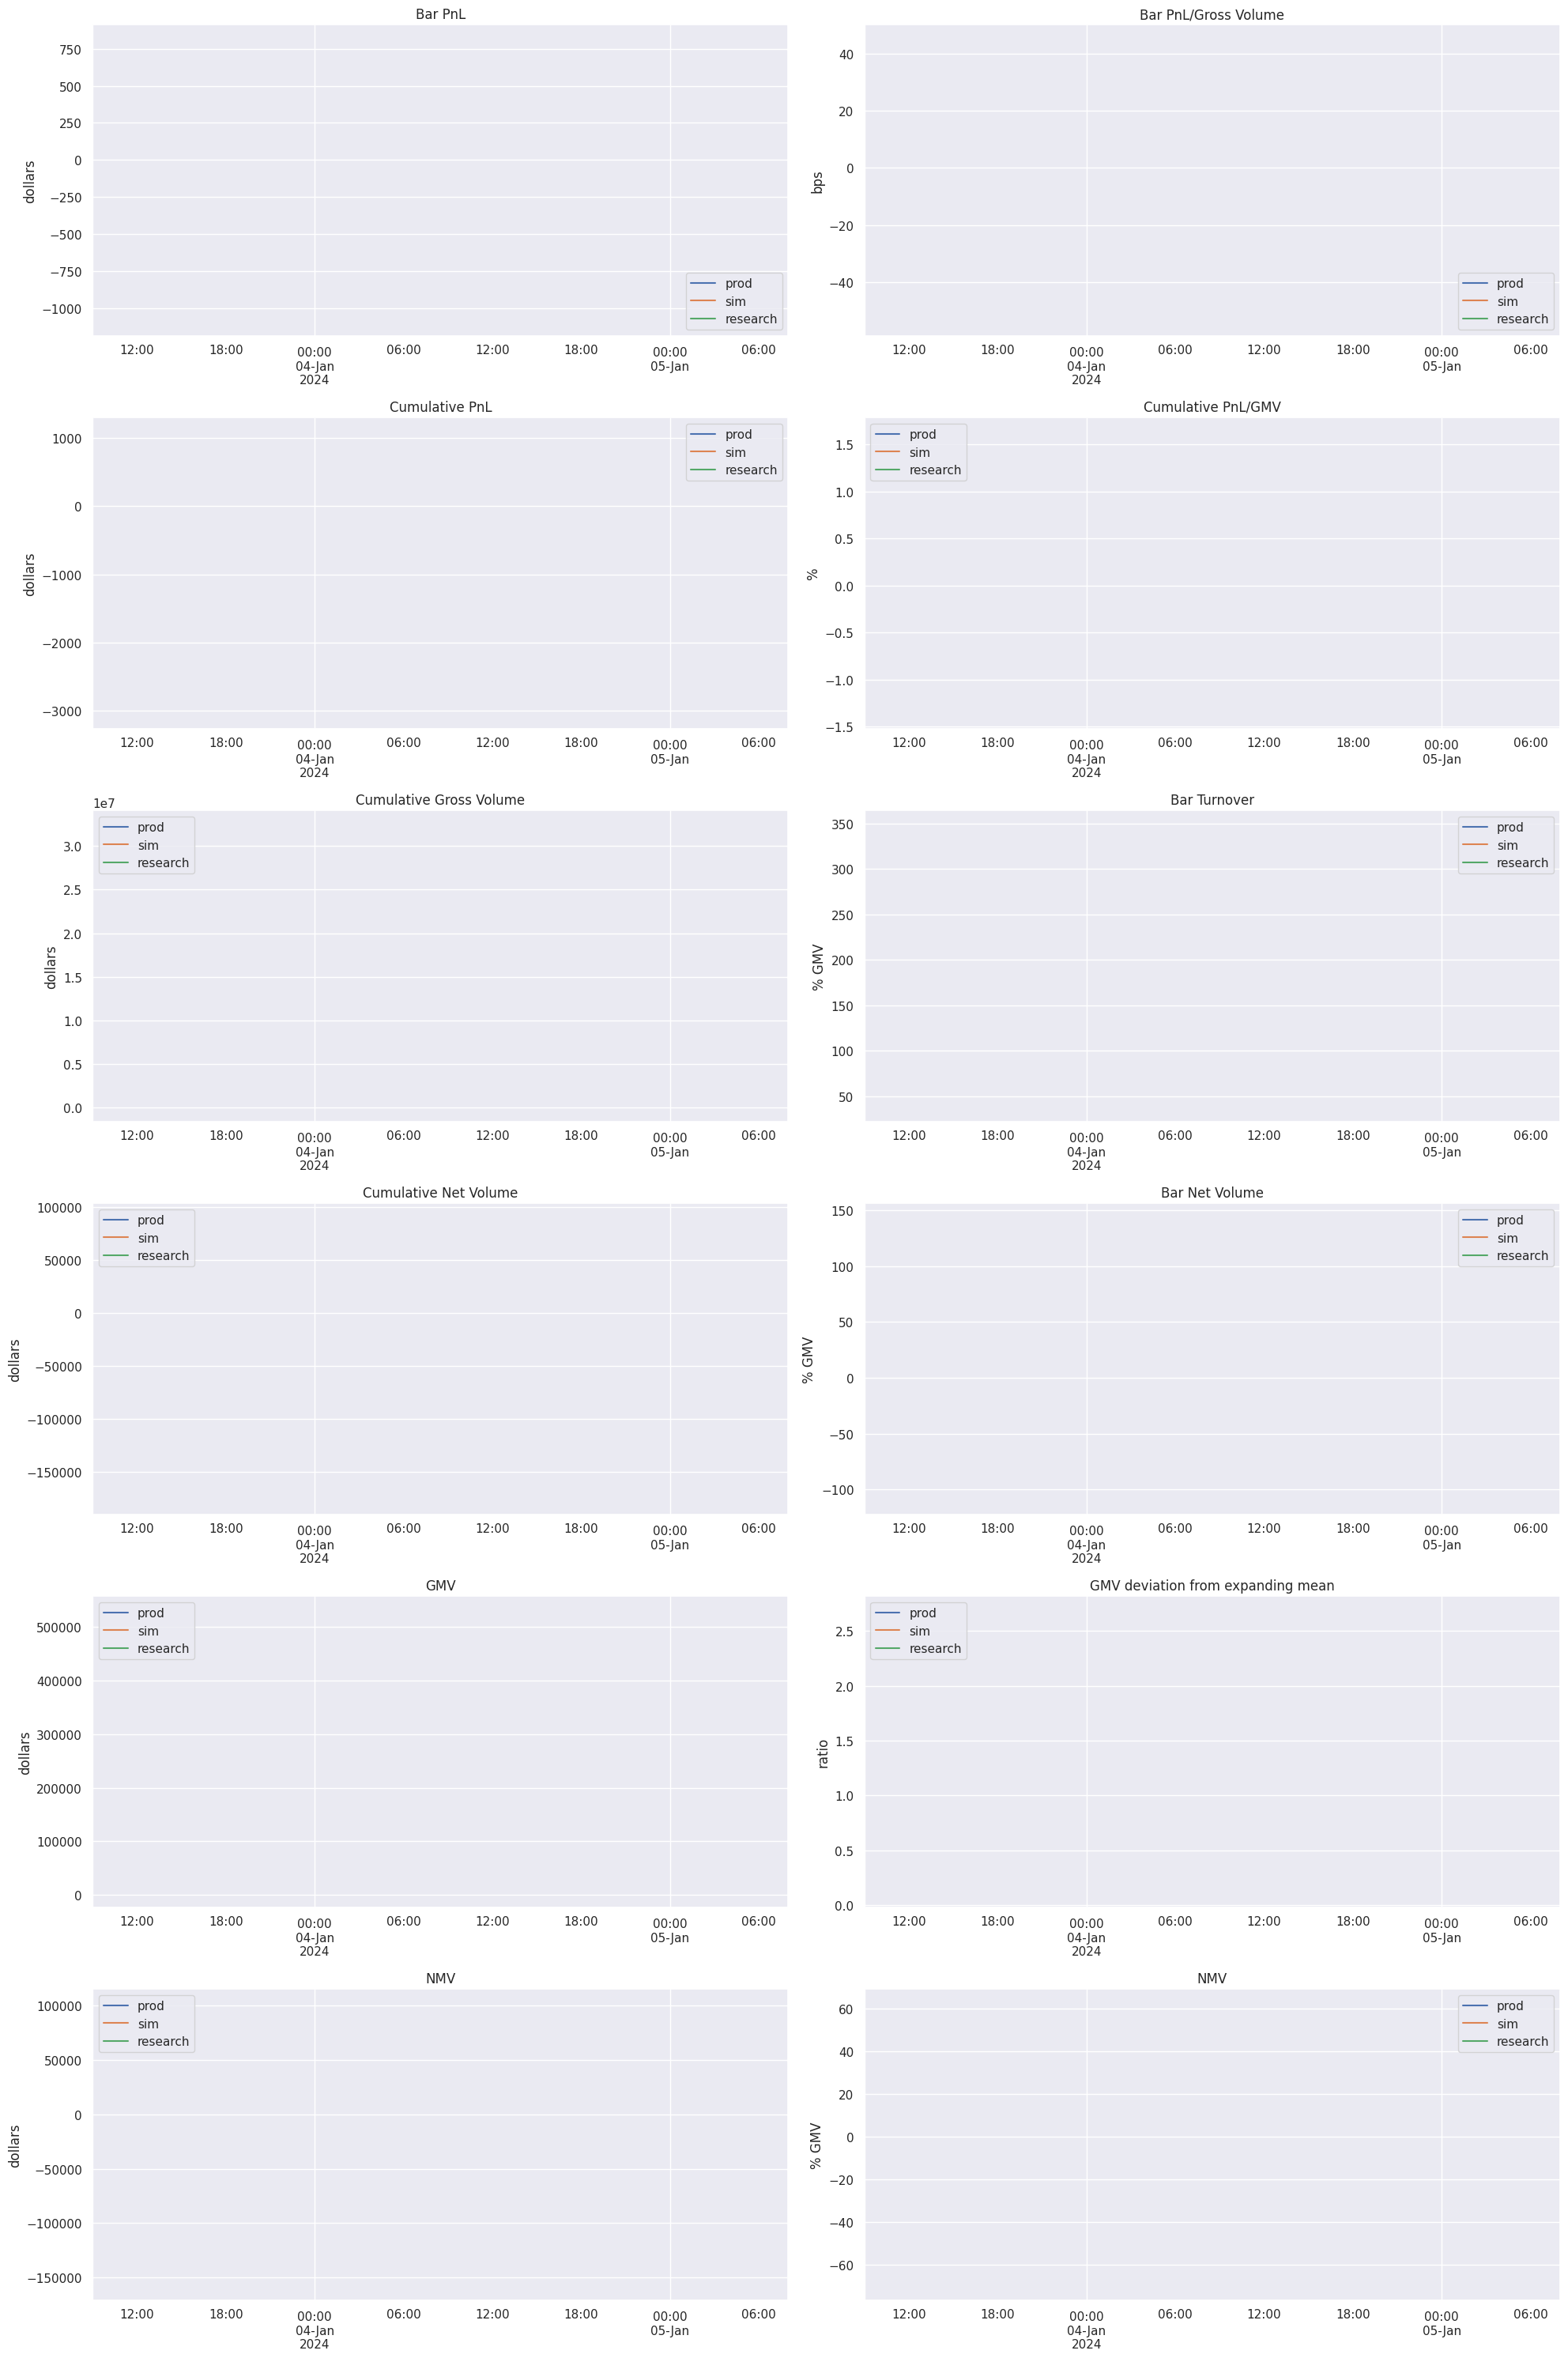

In [22]:
bars_to_burn = 1
coplotti.plot_portfolio_stats(
    portfolio_stats_df.iloc[bars_to_burn:],
    freq=config["pnl_resampling_frequency"],
)

In [23]:
stats_computer = dtfmod.StatsComputer()
stats_sxs, _ = stats_computer.compute_portfolio_stats(
    portfolio_stats_df.iloc[bars_to_burn:], bar_duration
)
display(stats_sxs)

prod        sim  research
ratios     sharpe_ratio                      0.34       0.34     14.47
           sharpe_ratio_standard_error      13.65      13.65     13.70
           sr.tval                           0.03       0.03      1.07
           sr.pval                           0.98       0.98      0.29
           kratio                           -5.03      -5.03     27.21
dollar     gmv_mean                     229990.08  229990.08   3002.67
           gmv_stdev                    114441.38  114441.38     42.96
           annualized_mean_return        14475.12   14475.12   8125.77
           annualized_volatility         42615.31   42615.31    561.49
           max_drawdown                   4138.13    4138.13     20.95
           pnl_mean                          0.83       0.83      0.49
           pnl_std                         323.63     323.63      4.36
           turnover_mean                341683.60  341683.60   3620.01
           turnover_stdev               133252.30  133252.30    778.55
           market_bias_mean              -1721.15   -1721.15   -145.85
           market_bias_stdev             53770.21   53770.21    727.22
percentage annualized_mean_return            6.29       6.29    270.62
           annualized_volatility            18.53      18.53     18.70
           max_drawdown                      1.80       1.80      0.70
           pnl_mean                          0.00       0.00      0.02
           pnl_std                           0.14       0.14      0.15
           turnover_mean                   148.56     148.56    120.56
           turnover_stdev                   57.94      57.94     25.93
           market_bias_mean                 -0.75      -0.75     -4.86
           market_bias_stdev                23.38      23.38     24.22

In [ ]:
# Correlate PnLs.
portfolio_stats_df[[("prod", "pnl"), ("sim", "pnl"), ("research", "pnl")]].corr()